In [1]:
import os
import pandas as pd
import optuna
import numpy as np
from qiskit.circuit import QuantumCircuit

import qtpu

from benchmark._plot_util import *

from benchmark.ansatz import qaoa2, qaoa1, random_ansatz, vqe, qml
from benchmark.exec_ckt import cut_ckt
from qtpu.compiler.compiler import compile_reach_size, find_best_trial
from benchmark.util import get_info, append_to_csv, concat_data
from qtpu.circuit import cuts_to_moves
from circuit_knitting.cutting.qpd import TwoQubitQPDGate

In [2]:
file_path = "results/compiler_12123.json"

In [70]:
n = 25

benches = [
    # vqe(200, 2),
    # qml(200, 2),
    qaoa1(10, 10, 1, 2),
    qaoa2(10, 10, 1, 2),
    # vqe(100, 2),
    # qml(50, 2),
    # qaoa1(5, 10, 1, 2),
    # qaoa2(5, 10, 1, 2),
]


for bench in benches:
    circuit, meta = bench
    # circuit = QuantumCircuit.from_qasm_file(
    #     "qasm/square-heisenberg/square_heisenberg_N25.qasm"
    # )

    qtpu_circ = compile_reach_size(
        circuit,
        n,
        pareto_fn=find_best_trial,
        show_progress_bar=True,
        n_trials=100,
        max_cost=(100, 1000000000),
    )

    qtpu_circ = cuts_to_moves(qtpu_circ)
    qtpu_overhead = np.prod(
        [
            instr.operation.basis.overhead
            for instr in qtpu_circ
            if isinstance(instr.operation, TwoQubitQPDGate)
        ]
    )
    qtpu_num_cuts = len(
        [instr for instr in qtpu_circ if isinstance(instr.operation, TwoQubitQPDGate)]
    )

    ckt_circ, ckt_info = cut_ckt(circuit, n)

    data = {
        "meta": meta,
        "ckt": ckt_info,
        "qtpu": {
            "overhead": qtpu_overhead,
            "num_cuts": qtpu_num_cuts,
        },
        # "qtpu_circ": qtpu_circ,
        # "ckt_circ": ckt_circ,
    }

    concat_data(
        file_path=file_path,
        data=data,
    )

    # data["qtpu_cost"].append(qtpu_overhead)

    # concat_data(
    #     file_path=file_path,
    #     data={**qtpu_info, **ckt_info},
    # )

[[100], [101], [102], [103], [104], [105], [106], [107], [108]]


  0%|          | 0/100 [00:00<?, ?it/s]

[3056.]
True
Found solution using 26 cuts with a sampling overhead of 9.79795730691229e+18.


  0%|          | 0/100 [00:00<?, ?it/s]

[1600. 1600. 1600. 1600.]
True
Found solution using 108 cuts with a sampling overhead of 7.443747734902289e+67.


In [3]:
# df = pd.read_json(file_path, normalize=True)
import json

with open(file_path, "r") as f:
    data = json.load(f)

df = pd.json_normalize(data)
df = df[df["meta.num_qubits"] <= 120]
dfs = {
    "VQE": df[df["meta.name"] == "vqe"].drop(columns=["meta.name"], inplace=False),
    "QML": df[df["meta.name"] == "qml"].drop(columns=["meta.name"], inplace=False),
    "QAOA I": df[df["meta.name"] == "qaoa1"].drop(columns=["meta.name"], inplace=False),
    "QAOA II": df[df["meta.name"] == "qaoa2"].drop(
        columns=["meta.name"], inplace=False
    ),
}
# df = df[df["meta.name"] == "qaoa1"]
# df = df.groupby(["meta.name", "meta.num_qubits"]).mean().sort_index()
# df["rel_cuts"] = df["qtpu.num_cuts"] / df["ckt.num_cuts"]


# df
# df["meta.name"]

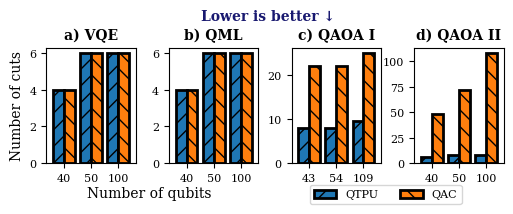

In [12]:
fig, axes = plt.subplots(1, len(dfs), figsize=(5.9, 1.5))
fig.subplots_adjust(wspace=0.37)

for i, (name, df) in enumerate(dfs.items()):
    ax = axes[i]
    df = df.groupby(["meta.num_qubits"]).mean().sort_index()
    # df["rel_overhead"] = df["qtpu.num_cuts"] / df["ckt.num_cuts"]
    df.plot.bar(
        y=["qtpu.num_cuts", "ckt.num_cuts"],
        ax=ax,
        rot=0,
        legend=False,
        # rot=0,
        width=0.8,
        edgecolor="black",
        linewidth=2,

        # capsize=3,
        # marker="v",
        # color="black",
        # legend=False,
    )
    ax.set_title(f"{chr(97+i)}) {name}", fontweight="bold")
    postprocess_barplot(ax)
    ax.set_xlabel(None)
axes[0].set_ylabel("Number of cuts")
    
    # ax.set_yscale("log")

fig.text(0.3, -.09, "Number of qubits", ha="center", va="center")
fig.text(
        0.5,
        1.09,
        "Lower is better ↓",
        ha="center",
        va="center",
        fontweight="bold",
        color="midnightblue",
    )

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, ["QTPU", "QAC"], loc="lower center", bbox_to_anchor=(0.7, -0.2), ncol=2)
# df.plot.bar(
#     y=["qtpu.num_cuts", "ckt.num_cuts"],
#     ax=ax,
#     rot=30,
#     legend=False,
#     # rot=0,
#     width=0.8,
#     edgecolor="black",
#     linewidth=2,

    # capsize=3,
    # marker="v",
    # color="black",
    # legend=False,
# )
# postprocess_barplot(ax)

In [13]:
fig.savefig("plots/02_compiler.pdf", bbox_inches="tight")

In [75]:
# qtpu_circ.draw(output="mpl")
# print(qtpu_circ.depth())
print(get_info(qtpu_circ))

{'qtpu_cost_log10': 3.6094876898532853, 'ckt_cost_log10': 7.339153355375986, 'num_qpds': 8, 'num_subcircuits': 5, 'num_instances': 3960, 'num_2q': 150, 'max_qubits': 20, 'depth': 54, 'esp': 0.857, 'base_qubits': 100, 'base_depth': 214, 'base_num_2q': 654, 'base_esp': 0.509}


In [5]:
ckt_circ.draw(output="mpl")

ValueError: Image size of 2228x89497 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 2228.98x89497.3 with 1 Axes>

In [6]:
qtpu_info

NameError: name 'qtpu_info' is not defined